# Training a Classifier
Generally, when you have to deal with image, text, audio or video data, you can use standard python packages that load data into a numpy array. Then you can convert this array into a `torch.*Tensor`.
- For *images*, packages such as `Pillow`, `OpenCV` are useful
- For *audio*, packages such as `scipy` and `librosa`
- For *text*, either raw Python or Cython based loading, or `NLTK` and `SpaCy` are useful

Specifically for vision, we have created a package called `torchvision`, that has data loaders for common datasets such as ImageNet, CIFAR10, MNIST, etc. and data transformers for images, viz., `torchvision.datasets` and `torch.utils.data.DataLoader`.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the **CIFAR10** dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

![Model](https://pytorch.org/tutorials/_images/cifar10.png)

### Exercise steps:
1. Load and normalize the CIFAR10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### Load and Normalize CIFAR10
Using `torchvision`, it's very easy to load CIFAR10.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


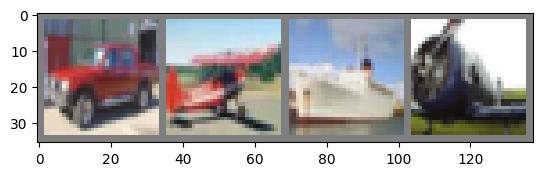

car   plane ship  plane


In [4]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Define a Convolutional Neural Network

In [5]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        # convolutional layers
        self.conv1 = nn.Conv2d(3, 6, 5) # 3 input channel, 6 output channels, 5 kernel size
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 input channels, 16 output channels, 5 kernel size

        # fully connected layerrs
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        # max pool
        self.pool = nn.MaxPool2d(2, 2)

        # activation function
        self.activation = F.relu

    def forward(self, x):
        # max pooling 2x2
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))

        # flatten all dimensions except the batch dimension
        x = torch.flatten(x, 1)
        
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)

        return x

In [6]:
network = Network()
network

Network(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

### Define a Loss function and Optimizer

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=0.001, momentum=0.9)

### Train the network

In [9]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get inputs. data: list[inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward prop
        out = network(inputs)

        # calculate loss
        loss = criterion(out, labels)

        # backprop
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.163
[1,  4000] loss: 1.835
[1,  6000] loss: 1.651
[1,  8000] loss: 1.576
[1, 10000] loss: 1.514
[1, 12000] loss: 1.444
[2,  2000] loss: 1.361
[2,  4000] loss: 1.348
[2,  6000] loss: 1.328
[2,  8000] loss: 1.273
[2, 10000] loss: 1.304
[2, 12000] loss: 1.282
Finished Training


Save the trained model. See [here](https://pytorch.org/docs/stable/notes/serialization.html) for more details on saving PyTorch models.

In [10]:
torch.save(network.state_dict(), './cifar_net.pth')

### Test the network on the test data
We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

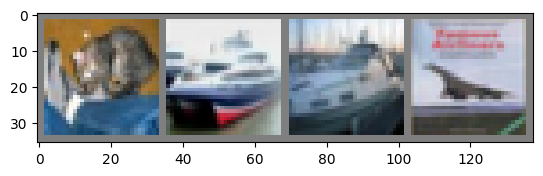

GroundTruth:  cat   ship  ship  plane


In [11]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, we load our model. (Not necessary in this case, for for DEMO reasons.)

In [12]:
network = Network()
network.load_state_dict(torch.load('./cifar_net.pth'))

<All keys matched successfully>

Now let us see what the neural network thinks these examples above are. The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy.

In [13]:
outputs = network(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   car   ship  plane


Not too bad, let's test on the whole dataset.

In [14]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = network(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 56 %


That is much better than randomly guessing them right, which would be `10%`! Clearly the model learned *something*.

Let's see which classes performed well and which did not.

In [16]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = network(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 58.5 %
Accuracy for class: car   is 83.4 %
Accuracy for class: bird  is 47.4 %
Accuracy for class: cat   is 34.5 %
Accuracy for class: deer  is 47.9 %
Accuracy for class: dog   is 41.7 %
Accuracy for class: frog  is 70.6 %
Accuracy for class: horse is 65.0 %
Accuracy for class: ship  is 57.7 %
Accuracy for class: truck is 54.4 %


### Training on the GPU
Just like how you transfer a Tensor onto the GPU, you transfer the neural net onto the GPU. Let's first define a device.

In [17]:
# Assuming that we are on a CUDA machine, this should print a CUDA device. I am currently not :)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

The rest of this section assumes that `device` is a CUDA device.

Then these methods will recursively go over all modules and convert their parameters and buffers to CUDA tensors

In [18]:
network.to(device)

Network(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

Remember that you will have to send the inputs and targets at every step to the GPU too:

In [19]:
inputs, labels = data[0].to(device), data[1].to(device)